# Remove response from 3C IGU16HR nodes
We can test different possibilities to remove the node responses.
Raw xml files are available on the NRL list:
https://ds.iris.edu/ds/nrl/datalogger/dtcc/smartsolo-igu-16hr3c/

In [68]:
import pandas as pd
import numpy as np
import obspy
import os
from obspy import read, Stream, UTCDateTime
from obspy.geodetics import gps2dist_azimuth
from obspy.core.trace import Stats, Trace
from obspy.clients.nrl import NRL
from obspy.core.inventory import Inventory, Network, Station, Channel, Site, read_inventory
from obspy.geodetics import gps2dist_azimuth

nrl = NRL()

# run the HVSR Minionology function notebook
%run 00_HVSR_Minionology_definitions.ipynb

C:\Users\koenvn\AppData\Local\Temp\ipykernel_11912\2043908955.py:15: ObsPyDeprecationWarning: 
        DEPRECATED

        Direct access to online NRL is deprecated as it will stop working when
        the original NRLv1 gets taken offline (Spring 2023), please consider
        working locally with a downloaded full copy of the old NRLv1 or new
        NRLv2 following instructions on the
        `NRL landing page <https://ds.iris.edu/ds/nrl/>`_.
        
  nrl = NRL()


## Checking  the SmartSolo NRL database:

In [5]:
print(nrl.sensors['DTCC (manuafacturers of SmartSolo)']) 

Select the DT-SOLO geophone model (2 items):
  'DT-SOLO', 'DT-SOLO-BB'


In [6]:
## For the 3C nodes, use the 5 Hz DT-SOLO model
print(nrl.sensors['DTCC (manuafacturers of SmartSolo)']['DT-SOLO']['5 Hz']) 

Select the resistor values of this geophone (2 items):
  'Rc=1850, Rs=430000', 'Rc=1850, Rs=None'


In [10]:
## we have the 'Rc=1850, Rs=430000' model
print(nrl.sensors['DTCC (manuafacturers of SmartSolo)']['DT-SOLO']['5 Hz']['Rc=1850, Rs=430000']) 

('DT-SOLO geophone, 5 Hz, Rc=1850 Ohms, Rs=43000 Ohms, 76.6 V/m/s', 'https://ds.iris.edu/NRL/sensors/dtcc/RESP.XX.NS680..SPZ.DTSOLO.5.1850.43000.76_6', 'RESP')


In [8]:
## For the 5s nodes ("Grus"), use the BB nodes
print(nrl.sensors['DTCC (manuafacturers of SmartSolo)']['DT-SOLO-BB']) 

('DT-SOLO-BB broadband geophone, 5 s, 209.4 V/m/s', 'https://ds.iris.edu/NRL/sensors/dtcc/RESP.XX.NS741..BHZ.DT-SOLO-BB_LP5_SG209.4_STgroundVel', 'RESP')


Different filters are available when pre-coding the 3C IGU16HR nodes. In the log file of the nodes you can read that following parameters are valid:
###### FINAL ANTIALIASING FILTER PHASE = 'Linear Phase'
###### DC FILTER = 'OFF'

Recheck this with the node laptop when pre-coding the nodes. Following figure shows the parameters for the SKIENCE2023 ski experiment.

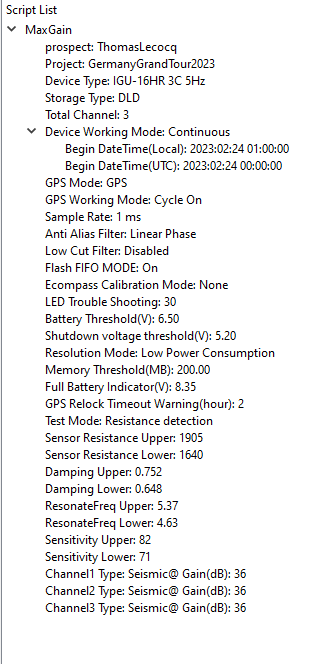

In [14]:
# load response from nrl - DATE 20240130
response_node = nrl.get_response(
        datalogger_keys=['DTCC (manufacturers of SmartSolo', 'SmartSolo IGU-16HR', '36 dB (64)', '250', 'Linear Phase', 'Off'], 
        sensor_keys=['DTCC (manuafacturers of SmartSolo)', 'DT-SOLO', '5 Hz', 'Rc=1850, Rs=430000']) 
response_node

Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 4.90427e+06 defined at 50.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 76.6
		Stage 2: ResponseStage from V to V, gain: 64
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 1000
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1

### NOTE:
I'm not sure in the **datalogger_keys** above if **'36 dB (64)'** loads the 'SmartSolo IGU-16HR' model, or if this already specifies the gain. Can find the alternative 0, 6, 12, 18, 24 gains. 
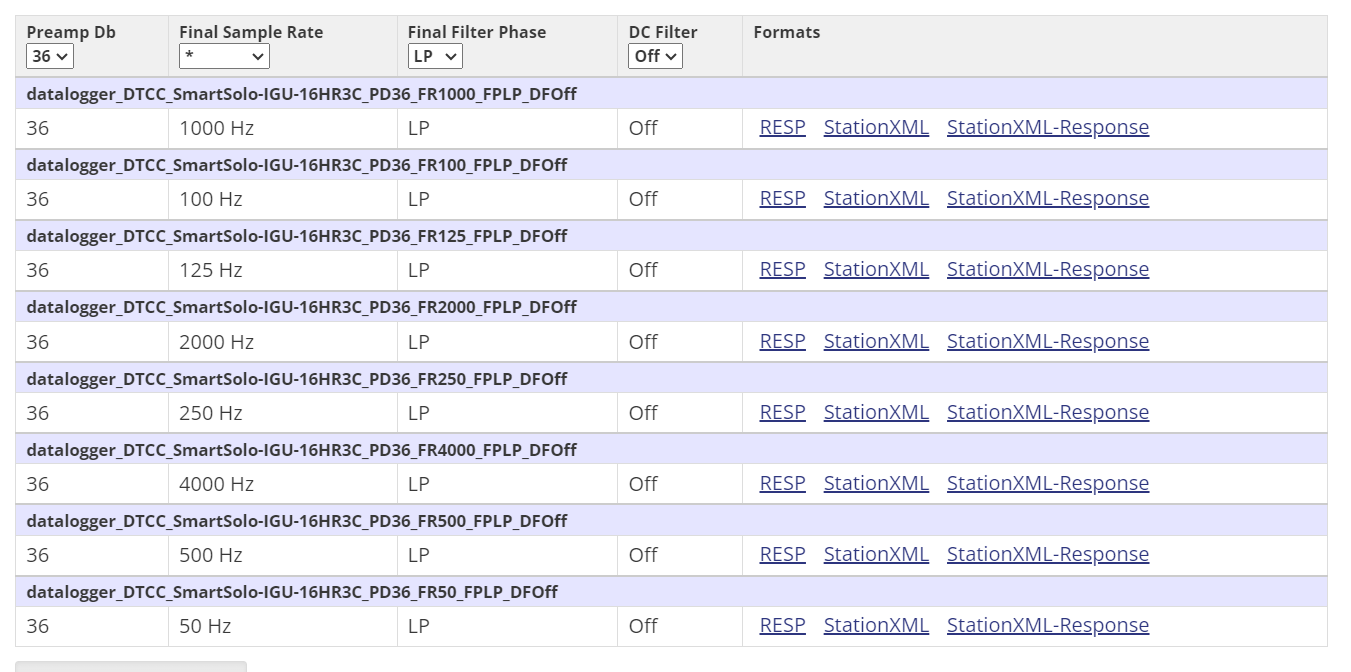

## Remove response from creating your own inventory and calling the NRL 
Example: https://docs.obspy.org/tutorial/code_snippets/stationxml_file_from_scratch.html

Note that **before 2024**, the code was 'DPZ'. This changed in 2024 with the new SoloLite software upgrade into code='GPZ'.  Change this in cha = Channel(

In [52]:
def create_inv(st, network, network_code, node_nr, station_lat, station_lon, elevation, site_name, 
    channel_code, channel_loc, xml_folder):

    inv = Inventory(
        # We'll add networks later.
        networks=[],
        source="Royal Observatory of Belgium")

    net = Network(
        # This is the network code according to the SEED standard - BE_ for nodes
        code=network_code,
        # A list of stations. We'll add one later.
        stations=[],
        description="SmartSolo 3C IGU16HR nodes - Seismology.be",
        # Start-and end dates when nodes were bought
        start_date=obspy.UTCDateTime(2021, 6, 1))

    sta = Station(
        # This is the station code according to the SEED standard.
        code=node_nr,
        latitude=station_lat,
        longitude=station_lon,
        elevation=elevation,
        site=Site(name=site_name))
    
    for tr in st:
        sample_rate = tr.stats.sampling_rate
        
    cha = Channel(
        # This is the channel code according to the SEED standard. - # (HH)(DP(Z)(N)(E) for nodes
        ### 2024 model
        # code='GPZ',
        
        #### note that before 2024 model, the code was 'DPZ'. This changed in 2024 with the new SoloLite software upgrade
        code='DPZ',
        
        # This is the location code according to the SEED standard.
        location_code=channel_loc,
        latitude=station_lat,
        longitude=station_lon,
        elevation=elevation,
        depth=0.0,
        azimuth=0.0,
        dip=-90.0,
        sample_rate=sample_rate)

    # By default this accesses the NRL online. Offline copies of the NRL can
    # also be used instead
    nrl = NRL()

    # load response from nrl - Datalogger keys have been changed 20240130
    response_node = nrl.get_response(
        datalogger_keys=['DTCC (manufacturers of SmartSolo', 'SmartSolo IGU-16HR', '36 dB (64)', '250', 'Linear Phase', 'Off'], 
        sensor_keys=['DTCC (manuafacturers of SmartSolo)', 'DT-SOLO', '5 Hz', 'Rc=1850, Rs=430000']) 
    
    # correct typo in gain
    response_node.response_stages[0].stage_gain = 76.7
    # add additional gain stage for node digitizer
    response_node.response_stages[1].stage_gain *= 3355.4428
    response_node.recalculate_overall_sensitivity()

    # Now tie it all together.
    cha.response = response_node
    sta.channels.append(cha)
    net.stations.append(sta)
    inv.networks.append(net)
    print(sta.code)
    
    # And finally write it to a StationXML file. We also force a validation against
    # the StationXML schema to ensure it produces a valid StationXML file.
    #
    # Note that it is also possible to serialize to any of the other inventory
    # output formats ObsPy supports.
    inv[0][0][0].channel_code = 'BE'
    inv.write('%s/%snodes.xml'%(xml_folder, node_nr), format="stationxml", validate=True)
    return inv

## Load the ski node locations and load xml

Note that here the data were already corrected for the gain. So gain = 0db here. But this info is not in the xml.

In [53]:
# mseed data
project_folder = r'C:\Users\koenvn\Nextcloud\Seismo Projects\SmartSolo_Nodes'
# to store the node xml files
xml_folder =  'ex5_2023_Ski_experiment'
# Skience_Ski
data_folder = os.path.join(project_folder, 'Skience2023_Ski')
node_locations = os.path.join(data_folder, 'Ski_Nodes_location.csv')
epi_lat, epi_lon =  47.679480, 12.039896
start_time = UTCDateTime('2023-03-01 12:35:0.0')
duration = 1 * 60
filestructure = '*.Z'
dataformat = 'miniseed'
title = 'Ski - Skience'

In [54]:
# read locations and add epicentral distance
df_loc = pd.read_csv(node_locations)
df_loc.Node, df_loc.lat, df_loc.lon
d_epi = []
for i,j in zip(df_loc.lat, df_loc.lon):
    d_epi.append(gps2dist_azimuth(epi_lat, epi_lon, i,j)[0])
df_loc["d_epi"] = d_epi

# Add node channel names from Node numbers
node_channels = []
for i in df_loc.Node:
    i = str(i)
    print(i)
    # network name not needed
    node_channels.append(i[-5:])

df_loc["node_channels"] = node_channels

df_loc = df_loc.set_index("Node")
df_loc = df_loc.sort_values(by=['d_epi'])

df_loc

453000039
453000617
453001013
453001195
453001250
453001960
453001974
453002695
453003484
453003625
453003798
453004248


C:\Users\koenvn\AppData\Local\Temp\ipykernel_11912\2798977265.py:6: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  d_epi.append(gps2dist_azimuth(epi_lat, epi_lon, i,j)[0])


,lat,lon,Z,Northing,Easting,Station,d_epi,node_channels
Node,,,,,,,,
453003798,47.679733,12.039328,1054.516,5285180.409,728110.003,N11,51.096442,03798
453003625,47.679566,12.039222,1058.467,5285161.457,728102.721,N10,51.530159,03625
453003484,47.679463,12.039130,1061.417,5285149.733,728096.277,N09,57.569448,03484
453004248,47.679901,12.039387,1051.387,5285199.232,728113.689,N12,60.443485,04248
453002695,47.679338,12.039020,1065.054,5285135.605,728088.610,N08,67.607582,02695
453001195,47.679648,12.039006,1056.765,5285169.923,728086.195,N04,69.368049,01195
453001250,47.679790,12.039071,1053.362,5285185.911,728090.442,N05,70.879851,01250
453001013,47.679538,12.038920,1060.510,5285157.461,728080.186,N03,73.590126,01013
453001960,47.679925,12.039112,1050.490,5285201.073,728092.905,N06,76.928714,01960


In [58]:
st = Stream()
for node in df_loc.index:
    filename = '%s%s.%s'%(node, filestructure, dataformat)

    st1 = Stream()
    st1 = read(os.path.join(data_folder, filename), starttime=start_time, endtime=start_time+duration)
    st1 = st1.select(component='*Z')  
    #create_inv?
    inv = create_inv(st1, 
                     "",
                     "BE", 
                     df_loc.loc[node].node_channels,
                     df_loc.loc[node].lat, 
                     df_loc.loc[node].lon,
                     df_loc.loc[node].Z, 
                     df_loc.loc[node].Station,
                     st1[0].stats.channel,
                     "",
                    xml_folder)
    print(inv)
    
    for tr in st1:
        print(tr)
        tr.attach_response(inv)
        tr.stats.distance = df_loc.loc[node].d_epi*1000
        tr.remove_response(output="VEL", pre_filt=(0.01,0.02,35,40))
        tr.detrend("demean")
        tr.taper(max_percentage=None, max_length=1)
        tr.filter("bandpass", freqmin=1, freqmax=10)
    
    st += st1
print(st)

C:\Users\koenvn\AppData\Local\Temp\ipykernel_11912\416153071.py:49: ObsPyDeprecationWarning: 
        DEPRECATED

        Direct access to online NRL is deprecated as it will stop working when
        the original NRLv1 gets taken offline (Spring 2023), please consider
        working locally with a downloaded full copy of the old NRLv1 or new
        NRLv2 following instructions on the
        `NRL landing page <https://ds.iris.edu/ds/nrl/>`_.
        
  nrl = NRL()


03798
Inventory created at 2024-02-28T09:26:25.283027Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: Royal Observatory of Belgium
	Contains:
		Networks (1):
			BE
		Stations (1):
			BE.03798 (N11)
		Channels (1):
			BE.03798..DPZ
BE.03798..DPZ | 2023-03-01T12:35:00.000000Z - 2023-03-01T12:36:00.000000Z | 1000.0 Hz, 60001 samples
03625
Inventory created at 2024-02-28T09:26:25.720168Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: Royal Observatory of Belgium
	Contains:
		Networks (1):
			BE
		Stations (1):
			BE.03625 (N10)
		Channels (1):
			BE.03625..DPZ
BE.03625..DPZ | 2023-03-01T12:35:00.000000Z - 2023-03-01T12:36:00.000000Z | 1000.0 Hz, 60001 samples
03484
Inventory created at 2024-02-28T09:26:26.105533Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: Royal Observatory of Belgium
	Contains:
		Networks (1):
			BE
		Stations (1):
			BE.03484 (N09)
		Channels (1):
			BE.03484..DPZ
BE.03484..DPZ | 2023-

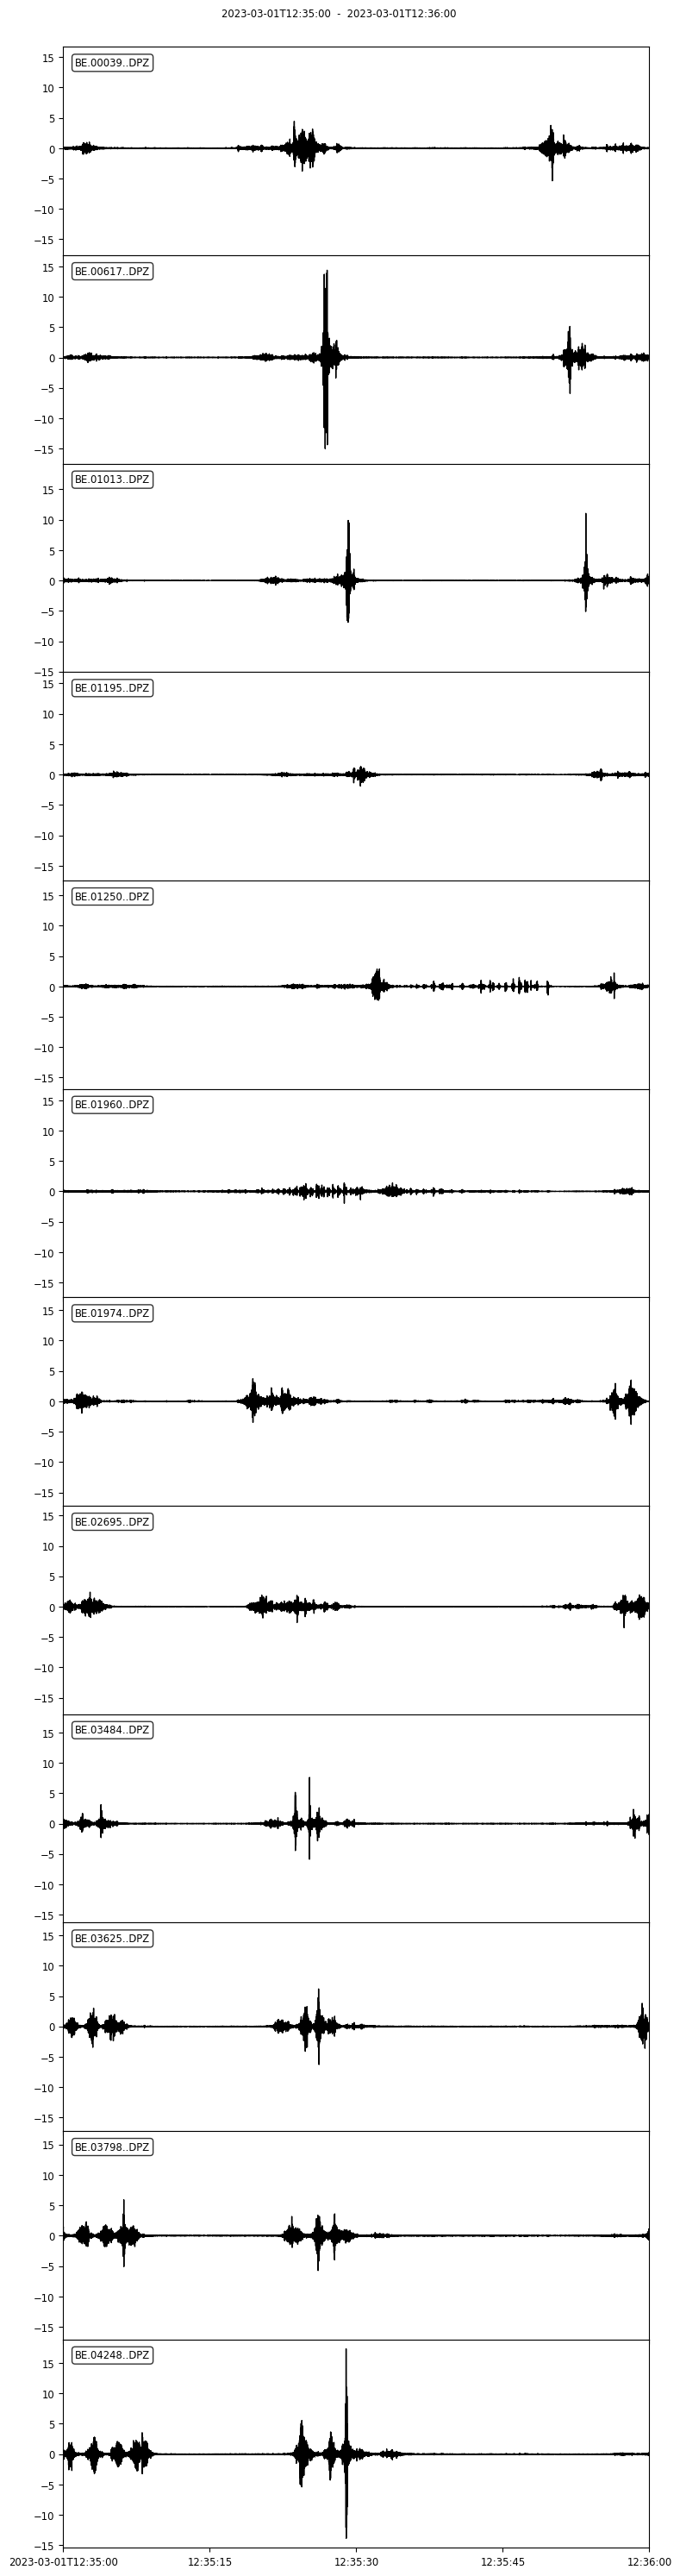

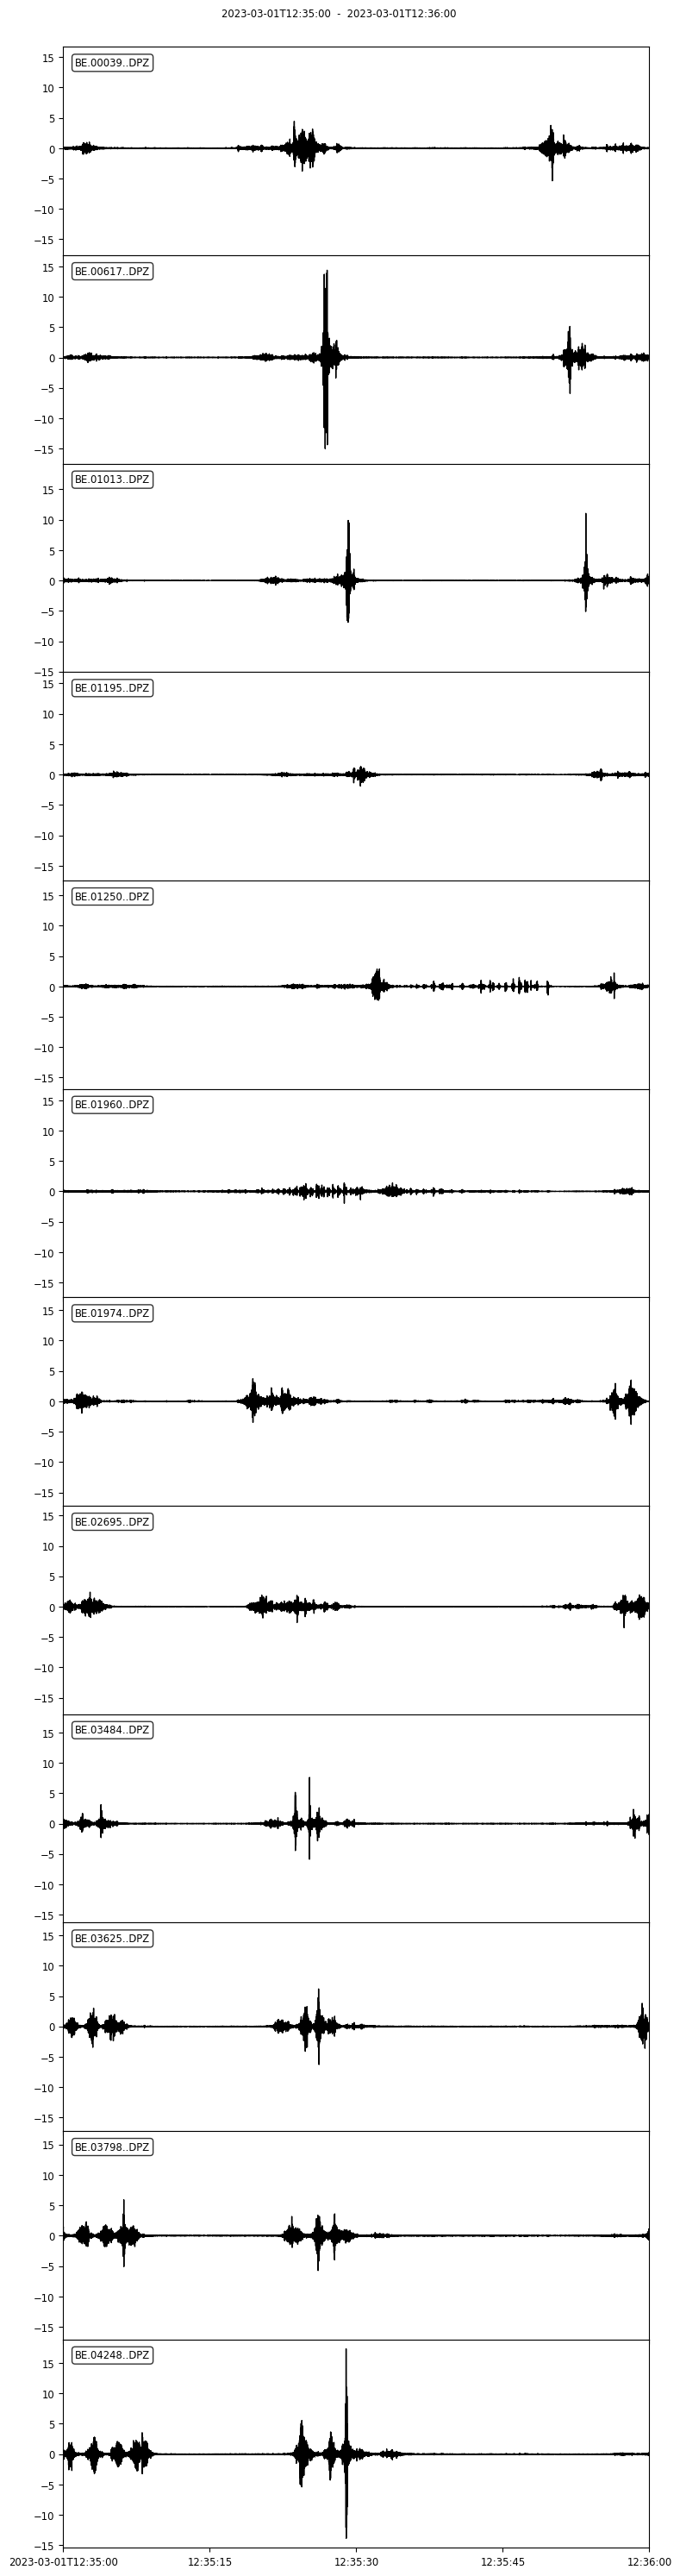

In [56]:
st.plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


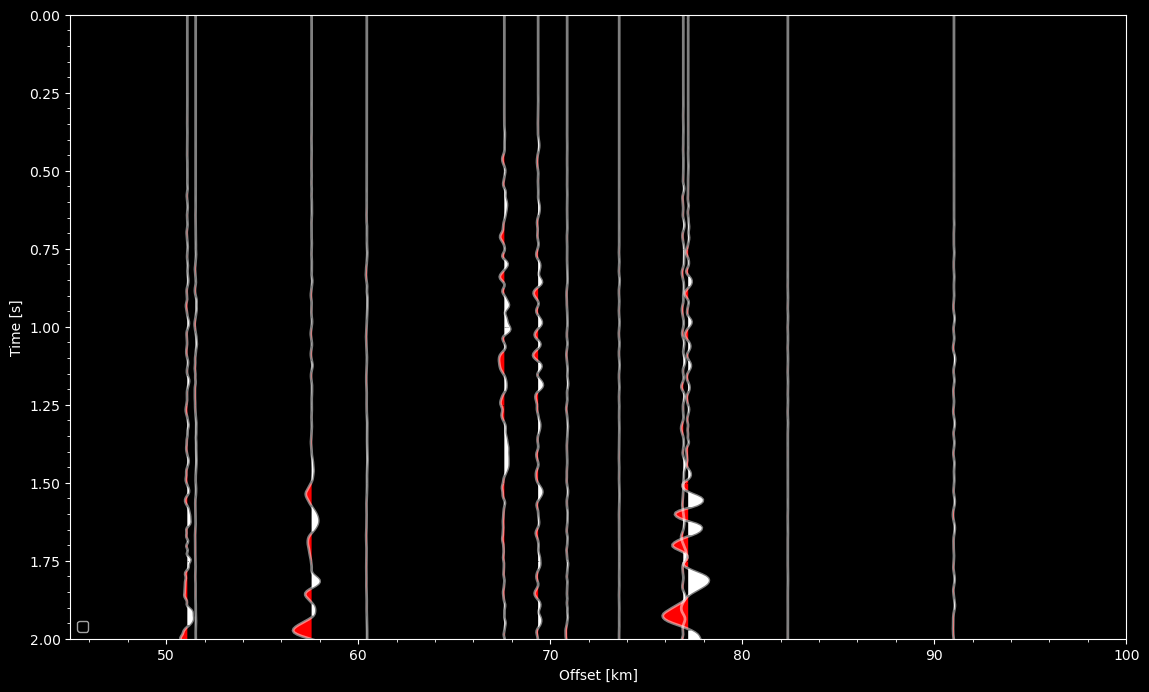

In [62]:
#print(st.__str__(extended=True))
plt.style.use('default')
plt.style.use('dark_background')

st.filter('bandpass', freqmin=0.5, freqmax=125)
fig = plt.figure(figsize=(12,8))

dt = st[0].stats.starttime
st.plot(type='section', starttime=dt, recordlength=2, linewidth=2, time_down=True, color = 'white',
        equal_scale = True, fillcolors = ('white','red'), fig=fig)

plt.xlim(45,100)
plt.legend(loc=3, fontsize = 10)

###

### Alternative 1, once you have one default station xml, you could modify it:

In [74]:
def fill_in_inv(xml, st, node_nr, station_lat, station_lon, elevation, site_name):
    
    '''
    read inventory from station XML and change params
    New Solite has a station location code: 'BE': 'nodes - IGU16_newSoloLite.xml' 
    Old Sololite has no station location code: '' : 'nodes - IGU16_oldSoloLite.xml'
    '''
    inv = read_inventory(xml)
    
    ## Station data
    inv[0][0].code = node_nr
    inv[0][0].latitude = station_lat
    inv[0][0].longitude = station_lon
    inv[0][0].elevation = elevation
    inv[0][0].site = Site(site_name)

    ## Channel data
    #inv[0][0][0].code = code
    #inv[0][0][0].channel_code = location_code
    
    inv[0][0][0].latitude = station_lat
    inv[0][0][0].longitude = station_lon
    inv[0][0][0].elevation = elevation
    stats = Stats()
    for tr in st:
        sample_rate = tr.stats.sampling_rate
    inv[0][0][0].sample_rate = sample_rate

    return inv

In [75]:
inv = fill_in_inv('ex5_2023_Ski_experiment\\00039nodes.xml', st,  df_loc.loc[node].node_channels, 
                  df_loc.loc[node].lat, df_loc.loc[node].lon, 0, df_loc.loc[node].Station)
inv

Inventory created at 2024-02-28T09:26:30.269142Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: Royal Observatory of Belgium
	Contains:
		Networks (1):
			BE
		Stations (1):
			BE.00039 (N01)
		Channels (1):
			BE.00039..DPZ

### Alternative 2: 

We could modify the download adress of the NRL database to directly download the correct response, with the gain included. 

The xml address of a 1000 Hz, 36 db, LF='off, Final Phase Filter: 'LP' is 
http://service.iris.edu/irisws/nrl/1/combine?instconfig=datalogger_DTCC_SmartSolo-IGU-16_PD36_FR1000_FPLP_DFOff&format=stationxml

**PD36** is the shortcut for 36 db

Julien Govoorts (UlB - ROB), wrote a download module to get this raw xml from NRL. We are still checking if all works properly:
https://github.com/ULB-SeismoLab/Minions-Toolbox/blob/main/response.ipynb

    path : path of the logfile - is a string
    idb : force the gain - From 0 to 36 B - is a integer, float or string
    ifs : force the sampling frequency - 50, 100, 125, 250, 500, 1000, 2000 or 4000 Hz - is a integer, float or string
    iFilter : force the Final Filter Phase - could be LP or MP - is a string
    iLC : force the DC Filter - could be 'OFF', '1' or 'DC' - is a string
      
    def find_response_file(path, idb = None, ifs = None, iFilter = None, iLC = None) :
    .
    .
    .
    
    url = "http://ds.iris.edu/NRL/dataloggers/dtcc/igu16hr3c/"
    page = urllib2.urlopen(url).read()
    name = '%i.%i.%s.%s' %(db[0], fs, Filter, LC)
    .
    .
    .
    